In [106]:
from modAL import batch, uncertainty, density, utils, disagreement
from modAL.models import ActiveLearner, Committee
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets, svm, metrics, tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import paired_distances
import numpy as np
from functools import partial
from typing import Union, Tuple
import pandas as pd
from art.attacks.evasion import FastGradientMethod, DeepFool
from art.estimators.classification.scikitlearn import SklearnClassifier
from copy import deepcopy

In [123]:
def active_split(X, Y, shuffle=True):
    """
    Split data into three sets:
    * Labeled training set (0.1)
    * Unlabeled training set, to be queried (0.4)
    * Labeled test set (0.5)
    """

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, shuffle=shuffle, random_state=42)
    X_labelled, X_unlabelled, Y_labelled, Y_oracle = train_test_split(X_train, Y_train, test_size=0.98, shuffle=shuffle, random_state=42)

    return X_labelled, X_unlabelled, Y_labelled, Y_oracle, X_test, Y_test

def active_learn(X, y, query_strategy, model='svm-linear', teach_advesarial=False) -> Tuple[list, list]:
    """
    Perform active learning on the given dataset using a linear SVM model, querying data with the given query strategy.

    Returns the accuracy curve.
    """
    X_labelled, X_unlabelled, Y_labelled, Y_oracle, X_test, Y_test = active_split(X, y, shuffle=True)
    if model == 'svm-linear':
        learner = ActiveLearner(
            estimator=svm.SVC(kernel='linear', probability=True), 
            X_training=X_labelled, 
            y_training=Y_labelled, 
            query_strategy=query_strategy
        )
    elif model == 'committee':
        learner = Committee(
            learner_list=[
                ActiveLearner(
                    estimator=svm.SVC(kernel='linear', probability=True), 
                    X_training=X_labelled, 
                    y_training=Y_labelled),
                # committee: logistic regression, svm-linear, svm-rbf, guassian process classifier
                ActiveLearner(
                    estimator=svm.SVC(kernel='rbf', probability=True), 
                    X_training=X_labelled, 
                    y_training=Y_labelled),
                ActiveLearner(
                    estimator=GaussianProcessClassifier(), 
                    X_training=X_labelled, 
                    y_training=Y_labelled),
                ActiveLearner(
                    estimator=LogisticRegression(), 
                    X_training=X_labelled, 
                    y_training=Y_labelled)
            ],
            query_strategy=disagreement.vote_entropy_sampling
        )
    else:
        raise Exception('unknown model')

    trained = [len(X_labelled)]
    accuracy = [learner.score(X_test, Y_test)]
    while len(X_unlabelled) != 0:
        if query_strategy == fgm:
            query_idx, advesarial_examples = learner.query(X_unlabelled)
        
            learner.teach(X_unlabelled[query_idx], Y_oracle[query_idx])
            if teach_advesarial:
                learner.teach(advesarial_examples, Y_oracle[query_idx])
        else:
            query_idx, _ = learner.query(X_unlabelled)
            learner.teach(X_unlabelled[query_idx], Y_oracle[query_idx])

        X_unlabelled = np.delete(X_unlabelled, query_idx, axis=0)
        Y_oracle = np.delete(Y_oracle, query_idx, axis=0)
        if model != 'committee':
            trained.append(trained[-1]+10)
        else:
            trained.append(trained[-1]+1)
        accuracy.append(learner.score(X_test, Y_test))
    return (trained, accuracy)

def random_batch(
    classifier: sklearn.base.BaseEstimator, 
    X: Union[list, np.ndarray], 
    n_instances: int = 1, 
    random_tie_break: bool = False, 
    **uncertainty_measure_kwargs
) -> Tuple[np.ndarray, np.ndarray]:
    idx = np.random.choice(X.shape[0], n_instances)
    return (idx, X[idx])

def fgm(
    classifier: sklearn.base.BaseEstimator, 
    X: Union[list, np.ndarray], 
    n_instances: int = 1, 
    random_tie_break: bool = False, 
    **uncertainty_measure_kwargs
) -> Tuple[np.ndarray, np.ndarray]:
    classifier = SklearnClassifier(model=classifier.estimator)
    attack = FastGradientMethod(estimator=classifier, eps=0.2)

    adversarial_examples = attack.generate(X)

    # TODO: I have no idea if this is the right way to rank them, it seems to be right intuitively but...
    dists = paired_distances(X, adversarial_examples, metric='euclidean')

    idx = np.argsort(dists)

    # This is kind of a hack, modAL is not built to deal with passing extra information.
    result =  (idx[:n_instances], adversarial_examples[idx[:n_instances]])

    return result

def deepfool(
    classifier: sklearn.base.BaseEstimator, 
    X: Union[list, np.ndarray], 
    n_instances: int = 1, 
    random_tie_break: bool = False, 
    **uncertainty_measure_kwargs
) -> Tuple[np.ndarray, np.ndarray]:
    classifier = SklearnClassifier(model=classifier.estimator)
    attack = DeepFool(classifier=classifier)

    adversarial_examples = attack.generate(X)

    # TODO: I have no idea if this is the right way to rank them, it seems to be right intuitively but...
    dists = paired_distances(X, adversarial_examples, metric='euclidean')

    idx = np.argsort(dists)

    # This is kind of a hack, modAL is not built to deal with passing extra information.
    result =  (idx[:n_instances], adversarial_examples[idx[:n_instances]])

    return result

In [3]:
def loadData_haberman():
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt'
    dataset = pd.read_csv(url, header=None)
    
    y = dataset[4].to_numpy()
    X = dataset.drop([4], axis=1).to_numpy()

    return X, y

In [4]:
X, y = loadData_haberman()

In [5]:
X.shape, y.shape

((1372, 4), (1372,))

In [81]:
fgm_adv_results = active_learn(X, y, partial(fgm, n_instances=10), teach_advesarial=True)
fgm_results = active_learn(X, y, partial(fgm, n_instances=10), teach_advesarial=False)

In [112]:
random_results = active_learn(X, y, partial(random_batch, n_instances=10))

(673, 4) (13, 4)
(663, 4) (13, 4)
(653, 4) (13, 4)
(643, 4) (13, 4)
(633, 4) (13, 4)
(623, 4) (13, 4)
(613, 4) (13, 4)
(603, 4) (13, 4)
(593, 4) (13, 4)
(583, 4) (13, 4)
(573, 4) (13, 4)
(563, 4) (13, 4)
(553, 4) (13, 4)
(543, 4) (13, 4)
(533, 4) (13, 4)
(523, 4) (13, 4)
(513, 4) (13, 4)
(503, 4) (13, 4)
(493, 4) (13, 4)
(483, 4) (13, 4)
(473, 4) (13, 4)
(463, 4) (13, 4)
(453, 4) (13, 4)
(443, 4) (13, 4)
(433, 4) (13, 4)
(423, 4) (13, 4)
(414, 4) (13, 4)
(404, 4) (13, 4)
(394, 4) (13, 4)
(384, 4) (13, 4)
(374, 4) (13, 4)
(364, 4) (13, 4)
(354, 4) (13, 4)
(344, 4) (13, 4)
(334, 4) (13, 4)
(324, 4) (13, 4)
(314, 4) (13, 4)
(304, 4) (13, 4)
(294, 4) (13, 4)
(284, 4) (13, 4)
(275, 4) (13, 4)
(265, 4) (13, 4)
(255, 4) (13, 4)
(245, 4) (13, 4)
(235, 4) (13, 4)
(225, 4) (13, 4)
(215, 4) (13, 4)
(205, 4) (13, 4)
(195, 4) (13, 4)
(185, 4) (13, 4)
(175, 4) (13, 4)
(165, 4) (13, 4)
(156, 4) (13, 4)
(146, 4) (13, 4)
(136, 4) (13, 4)
(126, 4) (13, 4)
(116, 4) (13, 4)
(106, 4) (13, 4)
(97, 4) (13, 4

In [83]:
us_results = active_learn(X, y, partial(batch.uncertainty_batch_sampling, n_instances=10))

In [92]:
deepfool_adv_results = active_learn(X, y, partial(deepfool, n_instances=10), teach_advesarial=True)

DeepFool: 100%|██████████| 3/3 [00:00<00:00, 18.52it/s]


In [124]:
committee_results = active_learn(X, y, partial(disagreement.vote_entropy_sampling, n_instances=10), model='committee')

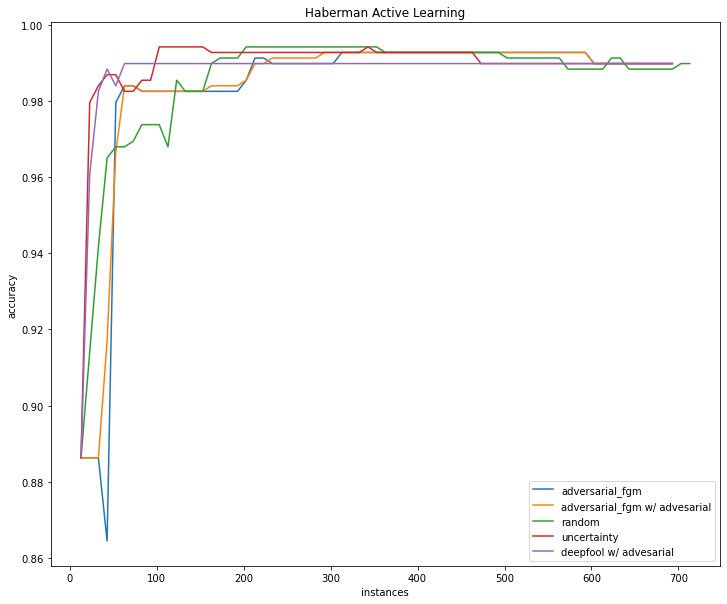

In [126]:
fig, ax = plt.subplots(figsize=(12,10))
ax.plot(fgm_results[0], fgm_results[1], label="adversarial_fgm")
ax.plot(fgm_adv_results[0], fgm_adv_results[1], label="adversarial_fgm w/ advesarial")
ax.plot(random_results[0], random_results[1], label="random")
ax.plot(us_results[0], us_results[1], label="uncertainty")
ax.plot(deepfool_adv_results[0], deepfool_adv_results[1], label="deepfool w/ advesarial")
#ax.plot(committee_results[0], committee_results[1], label="committee")
ax.legend()
ax.set_xlabel("instances")
ax.set_ylabel("accuracy")
ax.set_title("Haberman Active Learning");

In [128]:
# try use immitate to create biased (synthetic) initial sets for these
# see how active learning algorithms perform